In [4]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'


In [5]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [7]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df

significantLags: [1, 5, 8, 10, 19, 25, 45, 47, 50, 57, 64, 68]


,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10),(Close-19),(Close-25),(Close-45),(Close-47),(Close-50),(Close-57),(Close-64),(Close-68)
68,2020-12-08,216.626663,213.919998,194.919998,191.333328,173.949997,136.786667,133.503326,141.893326,149.386673,140.399994,141.143326,110.07000,158.350006
69,2020-12-09,201.493332,216.626663,189.606674,195.253326,185.126663,139.043335,141.300003,137.993332,138.363327,139.690002,147.383331,122.09333,149.123337


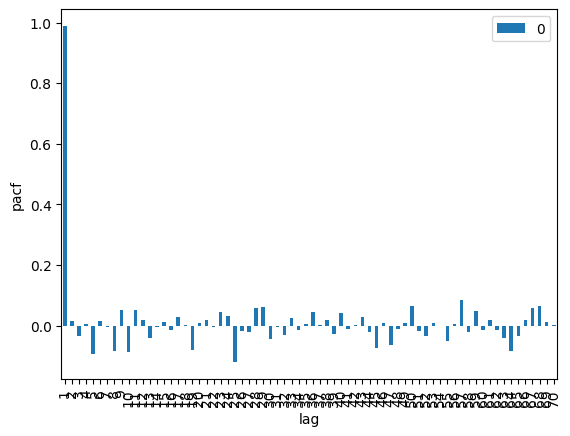

In [ ]:
tesla_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 70, alpha=0.05)

TM_tesla = appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)

In [9]:
def create_lagged_matrix(series, lags):
    n_rows = len(series) - max(lags)  # Usar o maior lag para calcular o número de linhas
    lagged_matrix = np.zeros((n_rows, len(lags)))
    
    for i, lag in enumerate(lags):
        lagged_matrix[:, i] = series[lag: lag + n_rows]
    
    return lagged_matrix

In [15]:
L = create_lagged_matrix(TM_tesla['Close'], tesla_significantLags)

Inicialmente, devemos criar nossa matriz da nossa série temporal, na bibliografia chame-se **Lagged Matrix**.

Seja a nossa série temporal $X = \{y_t\}_t^n$, podemos construir a nossa **Lagged Matrix** definida por L como sendo:
$$
L = \begin{pmatrix}
y_t & y_{t-1} & y_{t-2} & y_{t-3} & ... \\
y_{t+1}& y_t  & y_{t-1} & y_{t-2} & ... \\
 \vdots & \ddots & \vdots  & \ddots  & \vdots \\
 \cdots & \cdots & \cdots & \cdots & \cdots  \\
\end{pmatrix}
$$

Onde cada linha contém um conjunto de observações atrasadas da série.

In [16]:
L

array([[201.49333191, 211.08332825, 231.66667175, ..., 217.7333374 ,
        231.24333191, 217.72000122],
       [209.02333069, 207.58999634, 216.61999512, ..., 207.14666748,
        235.97999573, 218.28999329],
       [203.33000183, 218.6333313 , 213.44667053, ..., 199.31666565,
        225.62666321, 223.33332825],
       ...,
       [180.11000061, 176.19000244, 176.28999329, ..., 207.83000183,
        210.66000366, 205.75      ],
       [173.74000549, 178.78999329, 174.77000427, ..., 201.38000488,
        220.32000732, 206.27999878],
       [179.24000549, 178.08000183, 175.        , ..., 214.13999939,
        213.21000671, 214.11000061]])

In [17]:
# Aplicando a decomposição SVD
U, S, Vt = np.linalg.svd(L, full_matrices=False)

# Exibindo os componentes
print("Matriz U:")
print(U)
print("\nValores Singulares (S):")
print(S)
print("\nMatriz V transposta (V^T):")
print(Vt)

Matriz U:
[[-3.30671196e-02 -1.00276878e-02 -5.44263258e-02 ... -4.19395211e-02
   2.93214370e-02  6.55856226e-02]
 [-3.28798289e-02 -7.78546764e-03 -5.20946768e-02 ... -3.90916909e-02
   7.94546604e-05  3.76222954e-02]
 [-3.32876987e-02 -4.40732609e-03 -6.11831267e-02 ... -5.52574843e-02
   7.49214712e-04 -8.68149155e-03]
 ...
 [-2.75733730e-02 -2.24581761e-02 -1.30878421e-02 ... -5.17788700e-03
  -1.43928413e-02  1.86935514e-02]
 [-2.77070084e-02 -2.45627933e-02 -1.54018988e-02 ... -3.24788820e-02
  -3.52007166e-02  1.34086679e-02]
 [-2.78065149e-02 -2.28408793e-02 -9.79301123e-03 ...  2.94471045e-03
  -1.47560744e-02 -1.60777433e-03]]

Valores Singulares (S):
[24742.89484884  2552.10303557  1291.9320625   1013.88872088
   578.32990332   516.36031463   402.9930547    355.91466577
   300.03420618   287.60768005   230.98788909   221.33050595]

Matriz V transposta (V^T):
[[-0.28979971 -0.29015179 -0.29027482 -0.2902772  -0.29001785 -0.28942293
  -0.28831017 -0.28818328 -0.28787508 -0.28

Nosso objetivo é resolver o problema:

$$\hat{x} = \min_{x}\left\| y - \hat{y} \right\|^2 = \min_{x}\left\| y - Lx \right\|^2$$

via decomposição SVD.

Logo, nosso problema de mínimos quadrados via SVD ficará:

$$\hat{x} = \min_{x}\left\| y - \hat{y} \right\|^2 = \min_{x}\left\| y - U\Sigma V^T x\right\|^2 $$

- $U$ é uma matriz ortogonal de autovetores de $L^TL$

- $\Sigma$ é uma matriz diagonal contendo os valores singulares de $L$

- $V$ é uma matriz ortogonal de autovetores de $L^T L$.

O valor de $y$ a qual estamos considerando é **O VALOR DE FECHAMENTO DAS AÇÕES DA TESLA**.